# STock price prediction
**Group 14 Members:**
- Jason Arnold (Project Coordinator) – jarnol74@vols.utk.edu  
- Luke Tyler (Documentation) – ltyler2@vols.utk.edu  
- Jacob Mendez (Analysis for Visualization) – slc743@vols.utk.edu  
- Daniel Lillard (Analysis Lead – K-means) – danllill@vols.utk.edu

## Summary
This project used a machine learning prediction model to forecast stock prices 
and identify patterns in stock volatility for maximizing returns. 
    
Oleh Onyshchak’s stock market dataset included key financial indicators and over 8,000 stock tickers,
    offering an ample dataset for model training.

Machine learning has become increasingly valuable in stock market forecasting due to its ability to handle large data sets and recognize complex patterns. The paper by Ozcan (2023) highlighted how such models improve risk assessment and automation. However, ML should be seen as a supporting tool for decisions—not a guarantee of outcomes.


## Stocks Selected 

We are focusing on a curated list of stocks and ETFs based on availability in the dataset, trading volume, and relevance to different market sectors. These selections aim to capture a broad range of behaviors for modeling and clustering.


### Custom Selected Stocks

| Ticker | Name                                      | Status        |
|--------|-------------------------------------------|---------------|
| **AGNC** | AGNC Investment Corp.                   | In dataset  |
| **F**    | Ford Motor Company                       | In dataset  |
| **GME**  | GameStop Corp.                           | In dataset  |
| **KMI**  | Kinder Morgan, Inc.                      | In dataset  |
| **MO**   | Altria Group, Inc.                       | In dataset  |
| **OKE**  | ONEOK, Inc.                              | In dataset  |
| **PSEC** | Prospect Capital Corporation             | In dataset  |
| **VOC**  | VOC Energy Trust                         | In dataset  |
| **TSLA** | Tesla, Inc.                              | In dataset  |
| **EX**   | —                                        | Not found   |
| **XRP**  | — (Crypto, not NASDAQ-listed)            | Not found   |
| **BROS** | Dutch Bros Inc.                          | Not found   |

---

### Additional High-Volume Stocks that were recommended

| Ticker | Name                        |
|--------|-----------------------------|
| AAPL   | Apple Inc.                  |
| MSFT   | Microsoft Corporation       |
| AMZN   | Amazon.com Inc.             |
| NVDA   | NVIDIA Corporation          |
| META   | Meta Platforms              |
| JPM    | JPMorgan Chase & Co.        |
| XOM    | ExxonMobil                  |
| GLD    | SPDR Gold Shares (ETF)      |
| SLV    | iShares Silver Trust (ETF)  |
| BITO   | ProShares Bitcoin ETF       |

## References
**Datasets:**
- Oleh Onyshchak. Stock Market Dataset. Kaggle. https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset

**Books Referenced:**
- *Deep Learning with Python 2nd edition* 
  - Chapter 5: Fundamentals of Machine Learning
  - Chapter 10: Deep Learning for timeseries
  - Chapter 13: Best Practices for the Real World
- *Hands-On Machine Learning with Scikit-Learn and TensorFlow * 
  - Chapter 2: End-to-End Machine Learning Project
  - Chapter 4: Training Models
  - Chapter 6: Decision Trees


**Primary Objective:**
Use machine learning models to predict next-day stock prices and analyze volatility patterns using clustering.

We compared Linear Regression and Random Forest using features such as open, close, high, and low prices, volume, moving averages, and volatility. Based on price trends, we applied K-means clustering to group stocks.

*We experimented with:*
- Varying historical window sizes
- Injecting noise
- Modifying the feature set

**Evaluation **
- Mean Absolute Error (MAE)
- R-squared (R²)

We referenced a Kaggle notebook by Shivraj (March 2025) as a baseline, which used Random Forest achieving:
- **MAE      =** 0.0121
- **R-Squared=** 0.9953


In [11]:
import pandas as pd
import os

In [14]:
# Make sure update your path to individual stock CSVs
DATA_DIR = "./archive/stocks"

# Stocks we are focuing on which may change 
# a ticker of a stock is its kicer symbol as in Apple's is AAPL
tickers = ["AGNC", "F", "GME", "KMI", "MO", "OKE", "PSEC", "VOC", "TSLA"]
# we changed the original data set since only OKE, PSEC, TSLA, VOC had enough data points
#tickers = ["OKE", "PSEC", "VOC", "TSLA","AAPL","AMZN","NVDA","JPM","XOM"]
all_stocks = []

for ticker in tickers:
    file_path = os.path.join(DATA_DIR, f"{ticker}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, parse_dates=["Date"])
        df["Ticker"] = ticker  
        all_stocks.append(df)
    else:
        print(f"File not found for: {ticker}")

# Combine all into one DataFrame
combined_df = pd.concat(all_stocks, ignore_index=True)

File not found for: AGNC


In [15]:
# Count records per ticker
ticker_counts = combined_df["Ticker"].value_counts().sort_index()
print("Loaded Ticker Summary:\n")
print(ticker_counts)


Loaded Ticker Summary:

Ticker
F       12064
GME      4565
KMI      2300
MO      14664
OKE      9960
PSEC     3950
TSLA     2457
VOC      2241
Name: count, dtype: int64


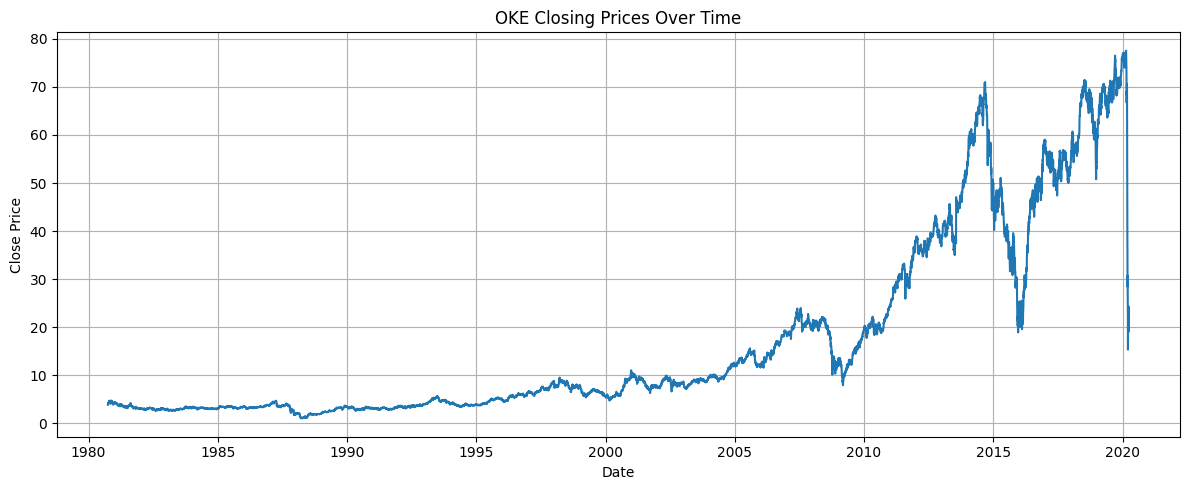

In [16]:
import matplotlib.pyplot as plt

# Plot close prices for TSLA (or any ticker)
#tsla_df = combined_df[combined_df["Ticker"] == "AGNC"]
tsla_df = combined_df[combined_df["Ticker"] == "OKE"]
plt.figure(figsize=(12, 5))
plt.plot(tsla_df["Date"], tsla_df["Close"])
plt.title("OKE Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
### Data Loading & Cleaning
# Loaded selected tickers: OKE, PSEC, VOC, TSLA, AAPL, AMZN, NVDA, JPM, XOM
# Verified data completeness
# Dropped missing and duplicate values
# Drop rows with any missing values 
combined_df.dropna(inplace=True)

# Remove duplicates
combined_df.drop_duplicates(inplace=True)

# Sanity check: Confirm which tickers are in the final dataset
print("Final tickers loaded:", combined_df["Ticker"].unique())
print("Rows after cleanup:", len(combined_df))
print("Row count per ticker:")
print(combined_df["Ticker"].value_counts().sort_index())

Final tickers loaded: ['F' 'GME' 'KMI' 'MO' 'OKE' 'PSEC' 'VOC' 'TSLA']
Rows after cleanup: 52198
Row count per ticker:
Ticker
F       12064
GME      4565
KMI      2299
MO      14663
OKE      9960
PSEC     3949
TSLA     2457
VOC      2241
Name: count, dtype: int64


In [18]:
### Feature Engineering
# Chapter 2 and chapter 4 of Hand-on Machine learning helped on this section
# Chapter on time seires also helped forht 10 and 5 day grouping.
# Moving Averages: MA5, MA10
# Daily Return and 5-day Volatility
# Next-day Close target 
def add_features(group):
    group = group.copy()
    group["MA5"] = group["Close"].rolling(window=5).mean() # 5 day grouping
    group["MA10"] = group["Close"].rolling(window=10).mean() # 10 day grouping
    group["Return"] = group["Close"].pct_change()
    group["Volatility"] = group["Return"].rolling(window=5).std()
    group["Close_tomorrow"] = group["Close"].shift(-1)
    return group

# Apply per ticker
combined_df = combined_df.groupby("Ticker").apply(add_features)

# Drop any resulting NaNs (from rolling and shift)
combined_df.dropna(inplace=True)

# Reset index if needed
combined_df.reset_index(drop=True, inplace=True)

# Sanity check
combined_df.head()

/tmp/ipykernel_2023/3788850781.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby("Ticker").apply(add_features)


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,MA5,MA10,Return,Volatility,Close_tomorrow
0,1972-06-14,2.108614,2.153220,2.108614,2.132945,0.002827,2939300.0,F,2.099693,2.118752,0.015444,0.009653,2.124835
1,1972-06-15,2.132945,2.153220,2.120780,2.124835,0.002816,1460700.0,F,2.105371,2.115914,-0.003802,0.008805,2.132945
2,1972-06-16,2.124835,2.132945,2.100504,2.132945,0.002827,750400.0,F,2.115103,2.114292,0.003817,0.007418,2.120780
3,1972-06-19,2.132945,2.145110,2.112669,2.120780,0.002811,529300.0,F,2.122402,2.111453,-0.005703,0.008648,2.128890
4,1972-06-20,2.120780,2.141055,2.120780,2.128890,0.002821,894100.0,F,2.128079,2.111859,0.003824,0.008334,2.108614


In [19]:
# mental check on the features
combined_df[["Ticker", "Date", "Close", "MA5", "MA10", "Return", "Volatility", "Close_tomorrow"]].head(10)


,Ticker,Date,Close,MA5,MA10,Return,Volatility,Close_tomorrow
0,F,1972-06-14,2.132945,2.099693,2.118752,0.015444,0.009653,2.124835
1,F,1972-06-15,2.124835,2.105371,2.115914,-0.003802,0.008805,2.132945
2,F,1972-06-16,2.132945,2.115103,2.114292,0.003817,0.007418,2.120780
3,F,1972-06-19,2.120780,2.122402,2.111453,-0.005703,0.008648,2.128890
4,F,1972-06-20,2.128890,2.128079,2.111859,0.003824,0.008334,2.108614
5,F,1972-06-21,2.108614,2.123213,2.111453,-0.009524,0.005936,2.096449
6,F,1972-06-22,2.096449,2.117536,2.111453,-0.005769,0.006124,2.092394
7,F,1972-06-23,2.092394,2.109426,2.112264,-0.001934,0.005047,2.084284
8,F,1972-06-26,2.084284,2.102126,2.112264,-0.003876,0.004941,2.100504
9,F,1972-06-27,2.100504,2.096449,2.112264,0.007782,0.006477,2.096449


In [20]:
from sklearn.model_selection import train_test_split

# Define your feature columns
features = ["Open", "High", "Low", "Close", "Volume", "MA5", "MA10", "Return", "Volatility"]

# Input features and target
X = combined_df[features]
y = combined_df["Close_tomorrow"]

### Train and Test split
# 80/20 which may change
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm sizes
print(f"Train size: {len(X_train)}")
print(f"Test size:  {len(X_test)}")


Train size: 41694
Test size:  10424


In [21]:
# Linear Regression Model 
from sklearn.linear_model import LinearRegression

# Initialize and fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr.predict(X_test)


In [22]:
# Random forest Regressor is the comparision model
from sklearn.ensemble import RandomForestRegressor

#  42 aka The Hikers guide to the Galaxy
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)


In [23]:
# store data for plots and comparisoin
# Add predictions to a DataFrame for comparison
results_df = X_test.copy()
results_df["Actual_Close"] = y_test.values
results_df["Pred_LR"] = y_pred_lr
results_df["Pred_RF"] = y_pred_rf

# Preview
results_df[["Actual_Close", "Pred_LR", "Pred_RF"]].head()


,Actual_Close,Pred_LR,Pred_RF
10674,14.210000,14.100415,14.108077
50828,5.630000,5.868913,5.967402
16050,19.959999,19.548164,19.927835
46610,8.230000,8.078021,8.194881
16723,26.049999,26.162355,25.955995


In [24]:
# Evaluations
from sklearn.metrics import mean_absolute_error, r2_score

print("Overall Evaluation:")
print("-------------------------------------")
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))
print("Random Forest MAE    :", mean_absolute_error(y_test, y_pred_rf))

print("Linear Regression R-Squerd :", r2_score(y_test, y_pred_lr))
print("Random Forest R-squared    :", r2_score(y_test, y_pred_rf))

Overall Evaluation:
-------------------------------------
Linear Regression MAE: 0.4729793323578276
Random Forest MAE    : 0.5006627352254327
Linear Regression R-Squerd : 0.9973253520107362
Random Forest R-squared    : 0.9952314691729129


In [26]:
# per a ticket aka stock as in the sublist we want:
# Append predictions and actuals
results_df = X_test.copy()
results_df["Actual_Close"] = y_test.values
results_df["Pred_LR"] = y_pred_lr
results_df["Pred_RF"] = y_pred_rf
results_df["Ticker"] = combined_df.iloc[X_test.index]["Ticker"].values

# Group by ticker and evaluate
tickers = results_df["Ticker"].unique()
print (tickers)
print("Per-Ticker Evaluation:")
# I need to find why my ticker (stocks) are not working
for ticker in tickers:
    subset = results_df[results_df["Ticker"] == ticker]
    # We found out some sets did not have enough data points and the original set I will have to change and some recommendations.
    # if len(subset) < 2:
    #   continue  # Not enough samples

    mae_lr = mean_absolute_error(subset["Actual_Close"], subset["Pred_LR"])
    mae_rf = mean_absolute_error(subset["Actual_Close"], subset["Pred_RF"])
    r2_lr = r2_score(subset["Actual_Close"], subset["Pred_LR"])
    r2_rf = r2_score(subset["Actual_Close"], subset["Pred_RF"])

    print(f" {ticker}:")
    print(f"  Linear Regression  - MAE: {mae_lr:.4f}, R-squared: {r2_lr:.4f}")
    print(f"  Random Forest  - MAE: {mae_rf:.4f}, R-squared: {r2_rf:.4f}")


['F' 'VOC' 'GME' 'PSEC' 'KMI' 'OKE' 'MO' 'TSLA']
Per-Ticker Evaluation:
 F:
  Linear Regression  - MAE: 0.1786, R-squared: 0.9986
  Random Forest  - MAE: 0.1530, R-squared: 0.9987
 VOC:
  Linear Regression  - MAE: 0.1787, R-squared: 0.9981
  Random Forest  - MAE: 0.1535, R-squared: 0.9983
 GME:
  Linear Regression  - MAE: 0.4569, R-squared: 0.9968
  Random Forest  - MAE: 0.4661, R-squared: 0.9969
 PSEC:
  Linear Regression  - MAE: 0.1667, R-squared: 0.9917
  Random Forest  - MAE: 0.1478, R-squared: 0.9912
 KMI:
  Linear Regression  - MAE: 0.3288, R-squared: 0.9970
  Random Forest  - MAE: 0.3425, R-squared: 0.9967
 OKE:
  Linear Regression  - MAE: 0.2714, R-squared: 0.9994
  Random Forest  - MAE: 0.2284, R-squared: 0.9994
 MO:
  Linear Regression  - MAE: 0.2959, R-squared: 0.9995
  Random Forest  - MAE: 0.2724, R-squared: 0.9993
 TSLA:
  Linear Regression  - MAE: 4.8094, R-squared: 0.9926
  Random Forest  - MAE: 5.8847, R-squared: 0.9867


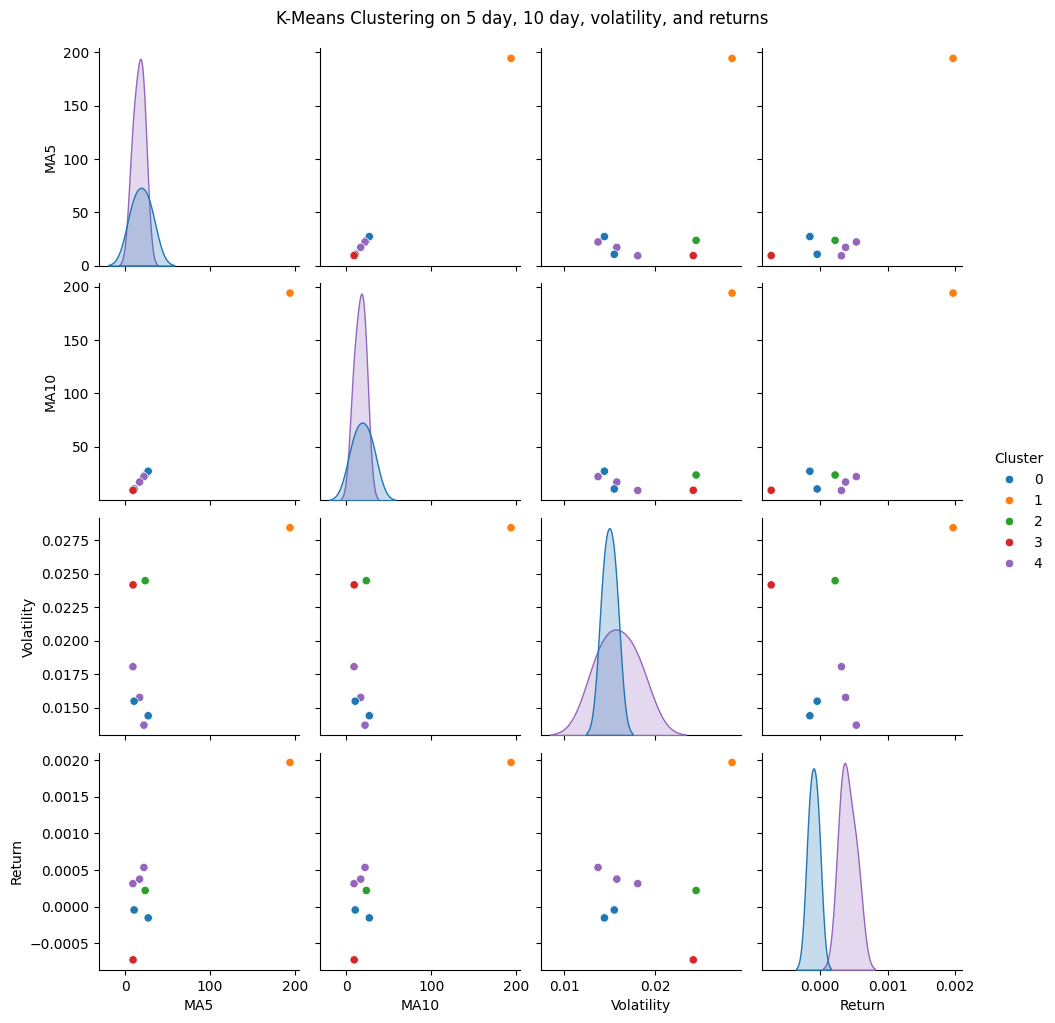

In [27]:
# I need to fix the grouping but for now going to make sure I get code:
# Clusterins with k-means  
# Chapter 8 helped with the visualizatoin code on this section
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Group by ticker and compute mean of selected features
agg = combined_df.groupby("Ticker")[["MA5", "MA10", "Volatility", "Return"]].mean()

# Scale features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(agg)

# we started with 5 clusters and may change and 42 aka The Hikers guide to the Galaxy
kmeans = KMeans(n_clusters=5, random_state=42)
agg["Cluster"] = kmeans.fit_predict(X_scaled)

# Testing reset index for plot for viusalizations 
agg.reset_index(inplace=True)

# Visualize clusters
sns.pairplot(agg, hue="Cluster", diag_kind="kde", palette="tab10")
plt.suptitle("K-Means Clustering on 5 day, 10 day, volatility, and returns", y=1.02)
plt.show()

In [28]:
# Clusters and tickets
for cluster_id in sorted(agg["Cluster"].unique()):
    tickers = agg[agg["Cluster"] == cluster_id]["Ticker"].tolist()
    print(f"Cluster {cluster_id}: {tickers}")


Cluster 0: ['KMI', 'PSEC']
Cluster 1: ['TSLA']
Cluster 2: ['GME']
Cluster 3: ['VOC']
Cluster 4: ['F', 'MO', 'OKE']
